# Experiment 3: LLava Approach -Clip Encoder/GPT2 Decoder

This experiment tests the LLava style projections using the HuggingFace Clip encoder and the gpt2 decoder. The experiment has two stages as outlined in the LLAva paper.

- **Stage One**: pretrains with the encoder and decoder frozen. The only trainable parameters at this stage are in the MLP used for image projections.

- **Stage Two**: performs fine-tuning with the decodr and MLP unfrozen. The pretrained MLP weights from stage one are loaded as the starting point for the MLP in stage two.

In [1]:
import os
import sys
import torch
import torch.nn as nn
from transformers import AutoTokenizer
import datetime
import logging
import warnings
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
warnings.filterwarnings("ignore", category=UserWarning)

"""
Add support for either running in collab by uploading this notebook and
mounting the directory or locally from the room or experiments folder"
"""
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # NOTE: change the drive path if running with a mounted google drive in collab
    project_root = "/content/drive/Othercomputers/My MacBook Pro/image-captioning"
else:
    cwd = os.getcwd()

    if cwd.endswith("experiments"):
        project_root = os.path.abspath(os.path.join(cwd, '..'))
    else:
        project_root = cwd

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

if IN_COLAB:
    !pip install evaluate > /dev/null 2>&1
    !pip install pycocoevalcap > /dev/null 2>&1


from vision_language_model import VisionLanguageModel
import train as train
import data_processing as dp
import download_data as get_data
import evaluation as eval


device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")

experiment = "experiment_3"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Mounted at /content/drive
Project root: /content/drive/Othercomputers/My MacBook Pro/image-captioning


In [2]:
# download data, keep it outside of the mounted directory if running in collab to avoid data transfer overhead
if IN_COLAB:
    data_dir = "/content/flickr30k_data"
else:
    data_dir = os.path.join(project_root, "flickr30k_data")

# only download data if it does not already exist
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    get_data.download_and_partition(data_dir)
else:
    print(f"Data already exists in {data_dir}, skipping download.")

# setup saving directories
model_weights_dir = os.path.join(project_root, "model_weights")
evaluations_dir = os.path.join(project_root, "evaluations")
os.makedirs(model_weights_dir, exist_ok=True)
os.makedirs(evaluations_dir, exist_ok=True)

Download complete.
Extracting dataset...
Extraction complete.
Partitioning images...
Partitioning complete: 25426 training images, 3178 validation images, 3179 test images.
Partitioning captions...
Dataset preparation complete.


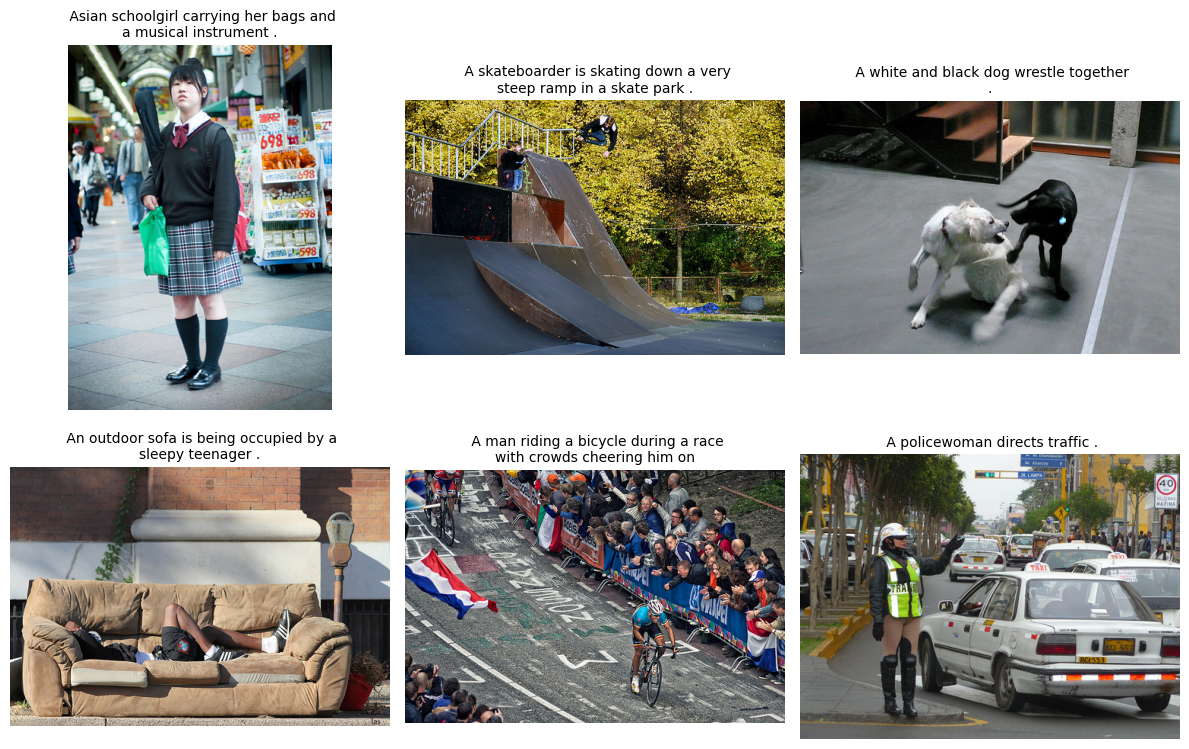

In [3]:
# load data
# Note: the train loader loads duplicate images with a 1:1 mapping of image to captions
# and the val/test loaders load images with a 1:N mapping of image to captions for evaluation
# these loaders will load batches of images rather than all images at once to avoid memory issues
train_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "train"), batch_size=4, eval_mode=False)
val_dir = os.path.join(data_dir, "val")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# visualize some training images
batch_1 = next(train_loader)
batch_2 = next(train_loader)
dp.visualize_random_captions([batch_1, batch_2])

## Stage One: Pretraining MLP

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# model config for stage one
model = VisionLanguageModel(
    image_encoder_type="clip",
    llava_projections=True,
    cross_attention=False,
    debug=False,
    decoder_type="gpt2",
    d_model=768,
    tokenizer=tokenizer
    ).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Initializing GPT-2 model...


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
%%time

max_batches=15000
num_epochs=1

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=4,
    num_epochs=num_epochs,
    training_type="mlp-pretrain",
    log_interval=1000,
    max_batches=max_batches,
    random_seed=1,
    lr_scheduler=True,
    learning_rate=2e-3,
    mlp_weights_path=os.path.join(model_weights_dir, f"{experiment}_pretrain_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_pretrain_loss_{timestamp}.jpg"),
    )

Encoder and decoder weights frozen for LLava-style MLP pre-training.

Epoch 1/1
Step 1000: Loss = 3.6755
Step 2000: Loss = 3.3795
Step 3000: Loss = 3.2515
Step 4000: Loss = 3.2024
Step 5000: Loss = 3.1432
Step 6000: Loss = 3.1076
Step 7000: Loss = 3.0366
Step 8000: Loss = 3.0493
Step 9000: Loss = 3.0247
Step 10000: Loss = 2.9796
Step 11000: Loss = 2.9982
Step 12000: Loss = 2.9784
Step 13000: Loss = 2.9803
Step 14000: Loss = 2.9635
Step 15000: Loss = 2.9492
MLP weights saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_3_pretrain_weights_2025-04-13_21-07-29.pt

Training complete.
CPU times: user 1h 4min 6s, sys: 16.6 s, total: 1h 4min 22s
Wall time: 1h 5min 15s


## Stage Two: Fine-tune

In [6]:
%%time
num_epochs=2
max_batches=3000

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=4,
    num_epochs=num_epochs,
    training_type="sft",
    max_batches=max_batches,
    log_interval=500,
    learning_rate=2e-4,
    random_seed=16,
    eval_every=2,
    model_weights_path=os.path.join(model_weights_dir, f"{experiment}_finetune_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_finetune_loss_{timestamp}.jpg"),
    all_epochs_loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_all_epochs_loss_{timestamp}.jpg")
)

Fine-tuning full decoder and MLP.

Epoch 1/2
Step 500: Loss = 3.3048
Step 1000: Loss = 3.1638
Step 1500: Loss = 3.0662
Step 2000: Loss = 3.0419
Step 2500: Loss = 2.9942
Step 3000: Loss = 2.9571

Epoch 2/2
Step 500: Loss = 2.4866
Step 1000: Loss = 2.3972
Step 1500: Loss = 2.3435
Step 2000: Loss = 2.3360
Step 2500: Loss = 2.3409
Step 3000: Loss = 2.3237


Sample Prediction: [' Asian boy walking down the sidewalk . One Asian family is waiting for their ride'], Reference: ['" Boy in backpack crossing the street , Other people , all Asian , are all in crosswalk walking towards the boy ."', ' One man with a yellow and orange backpack crosses the street as people approach him .', ' An asian male walking towards a group of people that are walking towards him .', ' A person is walking on a busy street while wearing a backpack .', ' a young boy walking down the road of a busy street .']
Epoch 2 - BLEU: 0.1046, CIDEr: 0.3382
Loss plot saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluations/experiment_3_all_epochs_loss_2025-04-13_21-07-29.jpg
Decoder model saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_3_finetune_weights_2025-04-13_21-07-29.pt

Training complete.
CPU times: user 37min 4s, sys: 7.69 s, total: 37min 12s
Wall time: 37min 30s


## Evaluate on Test Set

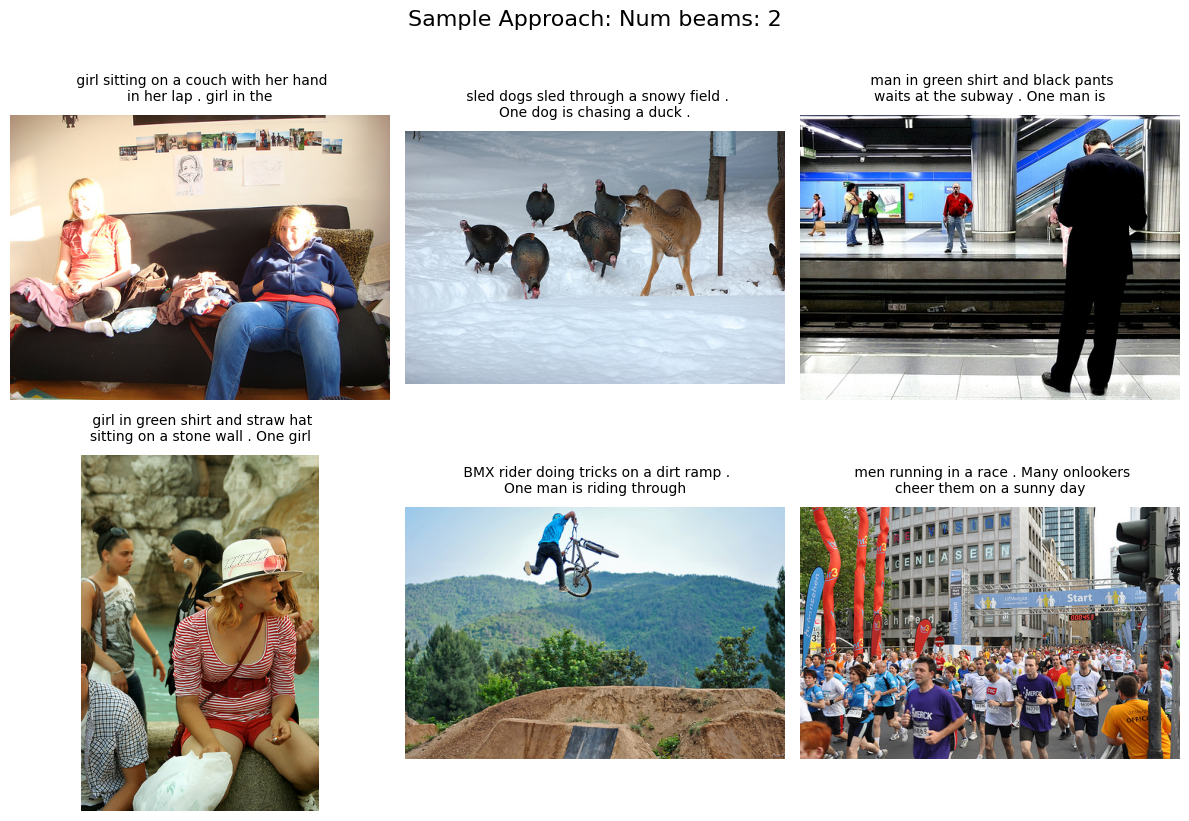

Sample Prediction: [' girl sitting on a couch with her hand in her lap . girl in the'], Reference: ['" Two women relax at home on a futon-style couch amidst pillows and a pile of clothing , with an array of photographs on the wall behind them ."', ' Two women sitting on a black sofa with clothes and a purse in between them .', ' Two girls sit on a couch in the bright sun and smile .', ' Two teen girl hanging out on the futon .', ' Two teen girls relax on a black futon .']
BLEU: 0.1022, CIDEr: 0.2981


In [7]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=4, eval_mode=True, seed=32)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=15,
    max_batches=250,
    num_beams=2
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

In [8]:
# save experiment results
results_path = os.path.join(evaluations_dir, "results.csv")

eval.save_experiment_results(experiment, cider, bleu, results_path)

Results saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluations/results.csv
